Markov state model for penta peptide
=====


In [1]:
import pyemma
pyemma.__version__

u'1.2+455.g034571f'

This notebook has been tested for version 1.2.1. If you are using a different version some adaptations may be required.

Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
import numpy as np
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Now we import the pyEMMA modules required later

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

WW-pentapeptide - load data
------

We first have to load the PDB file and the trajectory data, in this case for WW-pentapeptide.

In [4]:
indir = './data'
topfile =  indir+'/init-ww-penta.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which coordinates we would like to use in the further analysis. In this case simply the cartesian coordinates.

In [5]:
feat = coor.featurizer(topfile)
# just use all xyz-coordinates
feat.add_backbone_torsions()
#feat.add_backbone_torsions(cossin=True)
feat.describe()

['PHI 0 LEU 2 ',
 'PHI 0 ALA 3 ',
 'PHI 0 LEU 4 ',
 'PHI 0 LEU 5 ',
 'PSI 0 LEU 2 ',
 'PSI 0 ALA 3 ',
 'PSI 0 LEU 4 ',
 'PSI 0 LEU 5 ']

Now we load the coordinates and check the number of dimensions:

In [6]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

number of trajectories =  25
trajectory length =  10001
number of dimension =  8


These initial coordinates need to be transformed into sines and cosines (workaround, to be replaced by cossin option).

In [7]:
config['show_progress_bars']=False # no progress bars wanted here
stack_traj = []
for i in range(len(traj_list)):
    X = coor.load(traj_list[i], feat)
    cY=np.hstack((np.cos(X),np.sin(X)))
    stack_traj.append(cY)
st_traj = np.array(stack_traj)

Check the properties of the new dataset:

In [8]:
print 'number of trajectories = ',st_traj.shape[0]
print 'trajectory length = ',st_traj.shape[1]
print 'number of dimension = ',st_traj.shape[2]

number of trajectories =  25
trajectory length =  10001
number of dimension =  16


#TICA and clustering 

In [9]:
config['show_progress_bars']=True # progress bars can be activated again for this part
tica_lag = 1000      # tica lagtime
tica_dim = 2 # tica dimensions

In [10]:
tica_obj = coor.tica(stack_traj, lag=tica_lag, dim=tica_dim)

2015-07-18 21:26:11,523 coordinates.transform.TICA[26] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-18 21:26:11,523 coordinates.transform.TICA[26] INFO     Running TICA with tau=1000; Estimating two covariance matrices with dimension (16, 16)


In [11]:
Y = tica_obj.get_output() # get tica coordinates

Now we look at the distribution on the two dominant TICA coordinates

/home/nplattner/miniconda/envs/PyE-devR/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


<matplotlib.contour.QuadContourSet instance at 0x7f9123ae8440>

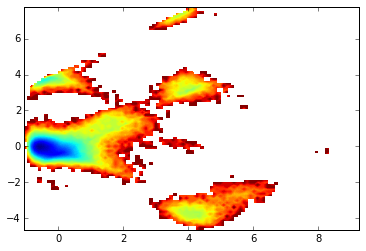

In [12]:
npY = np.array(Y)
npYc = np.concatenate(npY)
# histogram data
z,x,y = np.histogram2d(npYc[:,0],npYc[:,1], bins=100)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 100, extent=extent)

In [13]:
n_clusters = 200      # number of k-means clusters
cl_metric = 'euclidean' # clustering metric

In [14]:
clustering = coor.cluster_kmeans(Y,k=n_clusters)

2015-07-18 21:26:11,875 coordinates.clustering.KmeansClustering[28] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-18 21:26:16,201 coordinates.clustering.KmeansClustering[28] INFO     Accumulated all data, running kmeans on (250025, 2)
2015-07-18 21:26:19,680 coordinates.clustering.KmeansClustering[28] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [15]:
dtrajs = coor.assign_to_centers(Y, centers=clustering.clustercenters, stride=1, return_dtrajs=True, metric=cl_metric)

2015-07-18 21:26:19,683 coordinates.clustering.AssignCenters[30] INFO     reset (previous) parametrization state, since data producer has been changed.


In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories.

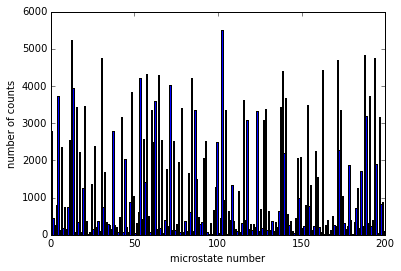

In [16]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

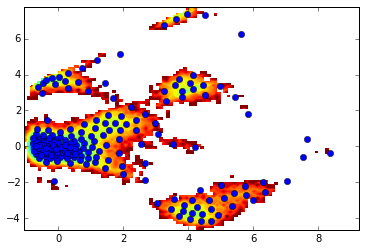

In [17]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
contourf(F.T, 100, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')

The states are well distributed in phase space.

#Implied timescales

In [18]:
lags = [1,2,5,10,15,20,30,50,75,100]
its = msm.timescales_msm(dtrajs, lags=lags, nits=5)

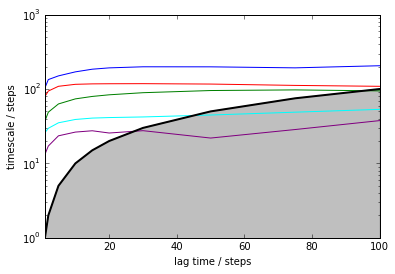

In [19]:
mpl.plot_implied_timescales(its)

In [20]:
#its_err = msm.timescales_msm(dtrajs,lags=lags,nits=5,errors='bayes')

In [21]:
#mpl.plot_implied_timescales(its_err)

# Estimate MSM

In [22]:
M = msm.estimate_markov_model(dtrajs, 30)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


From the Markov state model which is now stored in the object we called *M* various properties can be obtained. We start by analyzing the stationary distribution.

In [23]:
pi = M.stationary_distribution # stationary distribution
F_pi = -np.log(pi)  # free energy based on stationary distribution

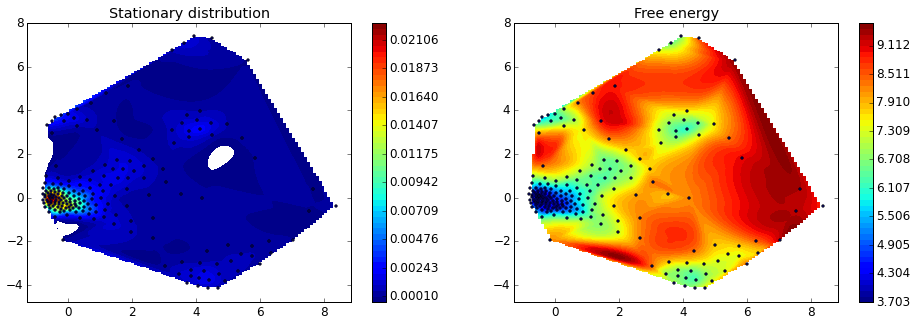

In [24]:
fig = plt.figure(figsize=(16,5))
matplotlib.rcParams.update({'font.size': 12})
ax1=plt.subplot(121)
ax1.set_title('Stationary distribution')
ax1 = mpl.scatter_contour(cc_x, cc_y, pi)

ax2=plt.subplot(122)
ax2.set_title('Free energy')
ax2 = mpl.scatter_contour(cc_x, cc_y, F_pi)

Now we analyze the slowest processes by looking at the distribution of states along the first 4 eigenvectors.

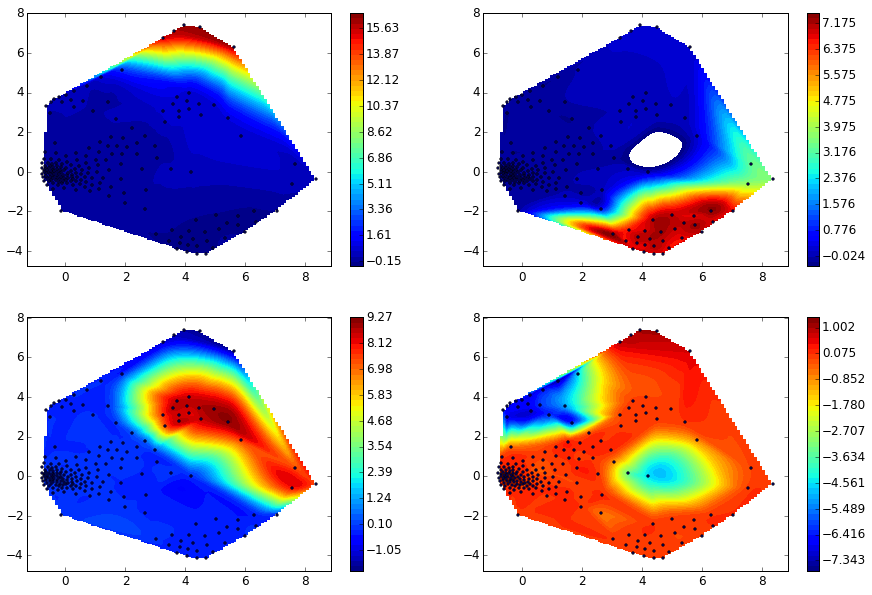

In [25]:
fig = plt.figure(figsize=(15,10))

ax1=plt.subplot(221)
r2 = M.eigenvectors_right()[:,1]
ax1 = mpl.scatter_contour(cc_x, cc_y, r2)

ax2=plt.subplot(222)
r3 = M.eigenvectors_right()[:,2]
ax2 = mpl.scatter_contour(cc_x, cc_y, r3)

ax3=plt.subplot(223)
r4 = M.eigenvectors_right()[:,3]
ax3 = mpl.scatter_contour(cc_x, cc_y, r4)

ax4=plt.subplot(224)
r5 = M.eigenvectors_right()[:,4]
ax4 = mpl.scatter_contour(cc_x, cc_y, r5)


Next the MSM is coarse grained into a user-defined number of macrostates (*n_sets*).

In [26]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships

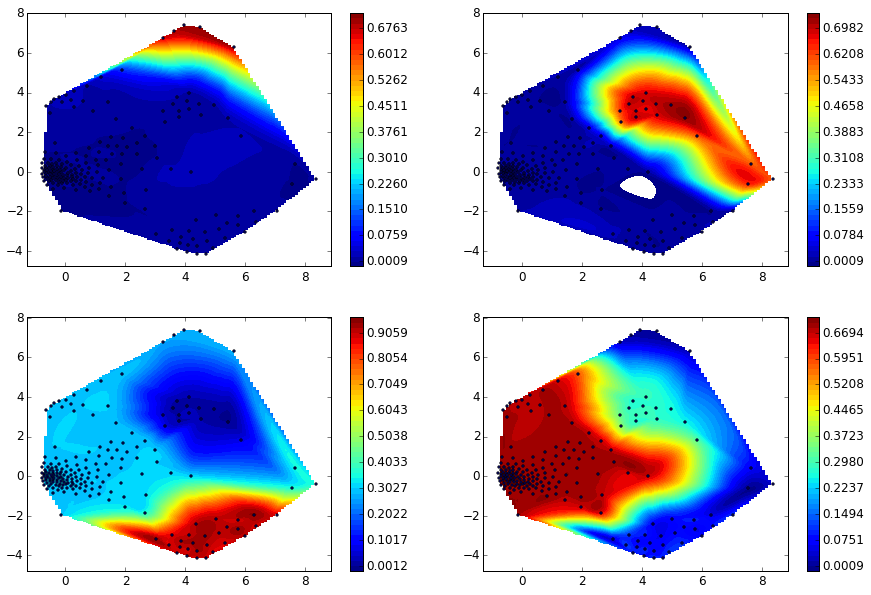

In [27]:
fig = plt.figure(figsize=(15,10))

ax1=plt.subplot(221)
ax1 = mpl.scatter_contour(cc_x, cc_y, membership[:,0])

ax2=plt.subplot(222)
ax2 = mpl.scatter_contour(cc_x, cc_y, membership[:,1])

ax3=plt.subplot(223)
ax3 = mpl.scatter_contour(cc_x, cc_y, membership[:,2])

ax4=plt.subplot(224)
ax4 = mpl.scatter_contour(cc_x, cc_y, membership[:,3])

In [28]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

In [29]:
coor.save_traj(inp, pcca_samples[0], './data/pcca1_10samples.xtc')
coor.save_traj(inp, pcca_samples[1], './data/pcca2_10samples.xtc')
coor.save_traj(inp, pcca_samples[2], './data/pcca3_10samples.xtc')
coor.save_traj(inp, pcca_samples[3], './data/pcca4_10samples.xtc')

2015-07-18 21:26:26,389 coordinates.api INFO     Created file ./data/pcca1_10samples.xtc
2015-07-18 21:26:26,744 coordinates.api INFO     Created file ./data/pcca2_10samples.xtc
2015-07-18 21:26:27,313 coordinates.api INFO     Created file ./data/pcca3_10samples.xtc
2015-07-18 21:26:27,821 coordinates.api INFO     Created file ./data/pcca4_10samples.xtc
